In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


In [30]:
df = pd.read_csv("wind_dataset.csv")

In [31]:
df.head(6)

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5
5,1961-01-06,10.67,0,0.0,0.0,6.5,0.0,1.2,-2.0


In [32]:
df = df[['DATE', 'WIND']].copy()
df=df[:1000]
df = df.set_index('DATE')
df= df[:1600]
df.head(10)

,WIND
DATE,
1961-01-01,13.67
1961-01-02,11.50
1961-01-03,11.25
1961-01-04,8.63
1961-01-05,11.92
1961-01-06,10.67
1961-01-07,9.17
1961-01-08,14.29
1961-01-09,8.04


In [33]:
#df['DATE'].size

In [34]:
df.index = pd.to_datetime(df.index)
# pd.to_datetime(df['DATE'], format='%Y-%m-%d')

In [35]:
df.head(10)

,WIND
DATE,
1961-01-01,13.67
1961-01-02,11.50
1961-01-03,11.25
1961-01-04,8.63
1961-01-05,11.92
1961-01-06,10.67
1961-01-07,9.17
1961-01-08,14.29
1961-01-09,8.04


In [36]:
def train_test(df, test_periods):
    train = df[:-test_periods].values
    test = df[-test_periods:].values
    return train, test
test_periods = 8 #200
train, test = train_test(df, test_periods)

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

In [38]:
train_scaled = torch.FloatTensor(train_scaled)
print(f'Original dimensions : {train_scaled.shape}')
train_scaled = train_scaled.view(-1)
print(f'Correct dimensions : {train_scaled.shape}')

Original dimensions : torch.Size([992, 1])
Correct dimensions : torch.Size([992])


In [39]:
def get_x_y_pairs(train_scaled, train_periods, prediction_periods):
    """
    train_scaled - training sequence
    train_periods - How many data points to use as inputs
    prediction_periods - How many periods to ouput as predictions
    """
    x_train = [train_scaled[i:i+train_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    y_train = [train_scaled[i+train_periods:i+train_periods+prediction_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    
    #-- use the stack function to convert the list of 1D tensors
    # into a 2D tensor where each element of the list is now a row
    x_train = torch.stack(x_train)
    y_train = torch.stack(y_train)
    
    return x_train, y_train

train_periods = 16 # 1000 -- number of quarters for input
prediction_periods = test_periods
x_train, y_train = get_x_y_pairs(train_scaled, train_periods, prediction_periods)
print(x_train.shape)
print(y_train.shape)

torch.Size([968, 16])
torch.Size([968, 8])


In [40]:
class LSTM(nn.Module):
    """
    input_size - will be 1 in this example since we have only 1 predictor (a sequence of previous values)
    hidden_size - Can be chosen to dictate how much hidden "long term memory" the network will have
    output_size - This will be equal to the prediciton_periods input to get_x_y_pairs
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        if hidden==None:
            self.hidden = (torch.zeros(1,1,self.hidden_size),
                           torch.zeros(1,1,self.hidden_size))
        else:
            self.hidden = hidden
            
        """
        inputs need to be in the right shape as defined in documentation
        - https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        
        lstm_out - will contain the hidden states from all times in the sequence
        self.hidden - will contain the current hidden state and cell state
        """
        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), 
                                          self.hidden)
        
        predictions = self.linear(lstm_out.view(len(x), -1))
        
        return predictions[-1], self.hidden

In [41]:
model = LSTM(input_size=1, hidden_size=50, output_size=test_periods)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
epochs = 80
model.train()
for epoch in range(epochs+1):
    for x,y in zip(x_train, y_train):
        y_hat, _ = model(x, None)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    if epoch%80==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

epoch:    0 loss:0.02158838
epoch:   80 loss:0.01550337


In [43]:
model.eval()
with torch.no_grad():
  predictions, _ = model(train_scaled[-train_periods:], None)
#-- Apply inverse transform to undo scaling
predictions= scaler.inverse_transform(np.array(predictions.reshape(-1,1)))


In [44]:
len(predictions)

8

In [45]:
#predictions=predictions[:100]

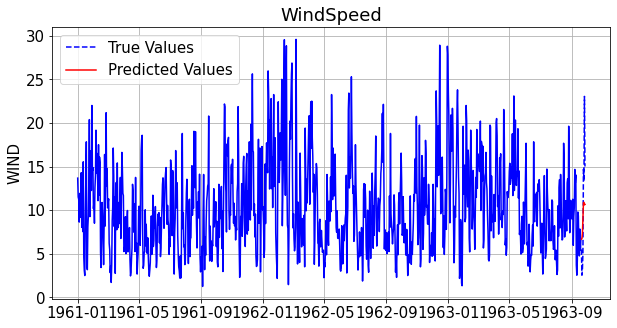

In [47]:
x = [dt.datetime.date(d) for d in df.index]
font = {'size'   : 15}

mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('WindSpeed')
plt.ylabel('WIND')
plt.grid(True)
plt.plot(x[:-len(predictions)],
         df.WIND[:-len(predictions)],
         "b-")
plt.plot(x[-len(predictions):],
         df.WIND[-len(predictions):],
         "b--",
         label='True Values')
plt.plot(x[-len(predictions):],
         predictions,
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)